In [15]:
# Import libraries
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spy
from tqdm import tqdm
import time
import pickle
from scipy.stats import chi2_contingency

# 결과 확인을 용이하게 하기 위한 코드
from IPython.core.interactiveshell import InteractiveShell
from statsmodels.stats.multitest import fdrcorrection

InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_rows',200)
pd.set_option('display.max_colwidth',None)

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

# icd version selection

In [16]:
ICD_VER=9

In [17]:
d_icd=pd.read_table("/data/mimic-iv-0.4/hosp/d_icd_diagnoses.csv", sep=',', index_col=0)
d_icd.index=d_icd.index.str.strip()
d_icd.loc['gender']=[ICD_VER, 'GENDER']
d_icd.loc['H_age']=[ICD_VER, 'AGE']

In [18]:
L2S={'Hypertensive chronic kidney disease with stage 1 through stage 4 chronic kidney disease':
     'Hypertensive chronic kidney disease',
     'Personal history of other venous thrombosis and embolism':
     'Personal history of other venous thrombosis',
     'Presence of coronary angioplasty implant and graft':
     'Presence of coronary angioplasty implant',
     'Atherosclerotic heart disease of native coronary artery without angina pectoris':
     'Atherosclerotic native coronary artery disease',
     'Long term (current) use of antithrombotics/antiplatelets':
     'Long term (current) use of antithrombotics',
     'Hypertrophy (benign) of prostate without urinary obstruction and other lower urinary tract symptom (LUTS)':
     'Hypertrophy of prostate with urinary obstruction',
     'Benign prostatic hyperplasia without lower urinary tract symptoms':
     'Benign prostatic hyperplasia w/o urinary tract symptoms',
     'Family history of ischemic heart disease and other diseases of the circulatory system':
     'Family history of ischemic heart disease',
     'Age-related osteoporosis without current pathological fracture':
     'Age-related osteoporosis w/o current fracture'}

def shorten_icd_name(name_list):
    shorten_name_list=[]
    for n1 in name_list:
        shorten_name_list.append(n1.split(',')[0])

    shorten_name_list=[L2S[n1] if n1 in L2S.keys() else n1 for n1 in shorten_name_list ]
    return shorten_name_list


<AxesSubplot:>

[748, 13497, 641, 13203]

(52, 4)

Index(['GENDER', 'AGE', 'Depressive disorder',
       'Long-term (current) use of anticoagulants',
       'Percutaneous transluminal coronary angioplasty status',
       'Aortocoronary bypass status', 'Personal history of tobacco use',
       'Personal history of transient ischemic attack (TIA)',
       'Urinary tract infection', 'Esophageal reflux',
       'Chronic airway obstruction', 'Pneumonia', 'Atrial fibrillation',
       'Coronary atherosclerosis of native coronary artery',
       'Old myocardial infarction', 'Acute kidney failure',
       'Diabetes mellitus without mention of complication', 'Anxiety state',
       'Anemia', 'Other and unspecified hyperlipidemia',
       'Pure hypercholesterolemia', 'Unspecified acquired hypothyroidism',
       'Obstructive sleep apnea (adult)(pediatric)',
       'Personal history of malignant neoplasm of breast', 'Osteoporosis',
       'Hypertrophy of prostate with urinary obstruction',
       'Aortic valve disorders',
       'Coronary atheros

(52, 5)

Text(0.5, 0.98, 'ICD-9')

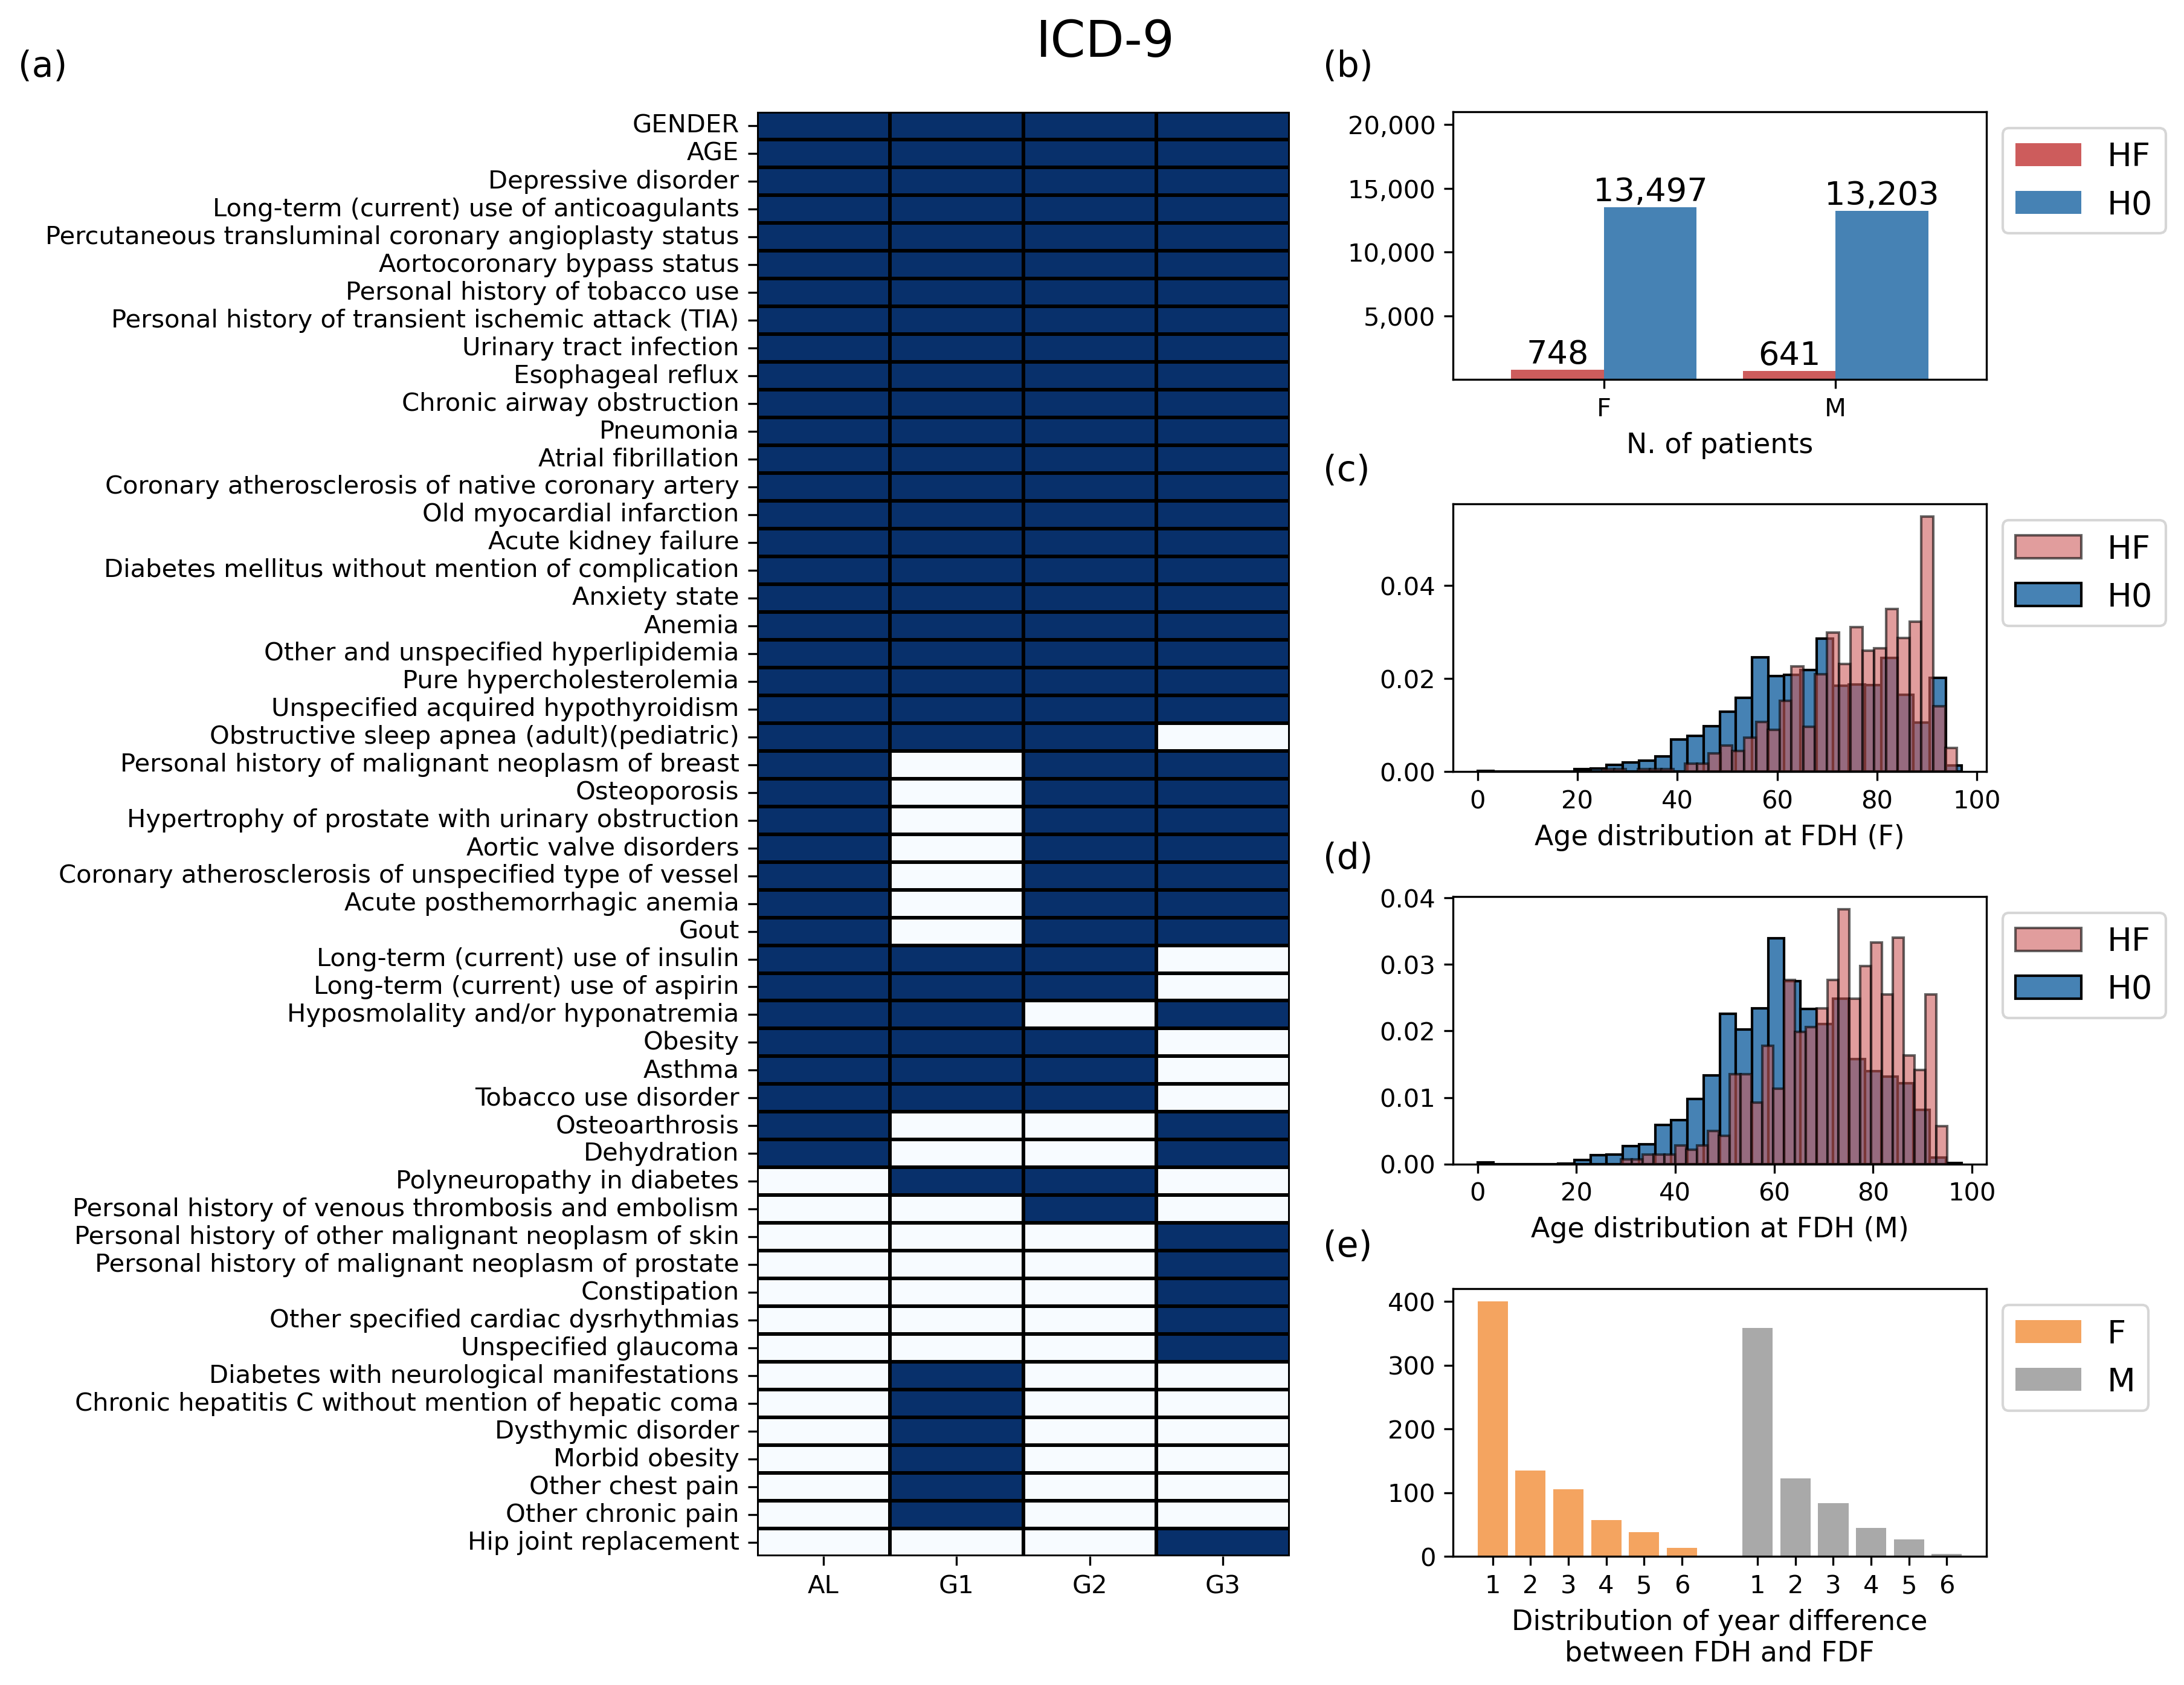

In [21]:
fig=plt.figure(figsize=(12,9.3), dpi=300)

ax1=fig.add_subplot(4,2,2)
ax2=fig.add_subplot(4,2,4)
ax3=fig.add_subplot(4,2,6)
ax4=fig.add_subplot(4,2,8)
ax5=fig.add_subplot(1,2,1)

H0C='steelblue'
HFC='indianred'

# H0C='mediumblue'
# HFC='darkred'

with open("./results/data_cl0_icd{}_0_120.pickle".format(ICD_VER), 'rb') as f:
    cl0_dat=pickle.load(f)
with open("./results/data_cl1_icd{}_0_120.pickle".format(ICD_VER), 'rb') as f:
    cl1_dat=pickle.load(f)

##########################
########## ax1 ###########
##########################
sr2=cl1_dat['gender'].value_counts()
sr3=cl0_dat['gender'].value_counts()

df1=pd.concat([sr2,sr3],axis=1)
df1=df1.loc[['F','M']]
df1.columns=['HF','H0']
sum_sr=df1.sum(axis=1)

df2=pd.DataFrame()
for col in df1.columns:
    df2[col]=df1[col]/sum_sr

df1.plot.bar(ax=ax1, color=[HFC, H0C],width=0.8)
_=ax1.tick_params(axis='x', labelrotation = 0)

_=ax1.legend(fontsize=13, loc='upper left', bbox_to_anchor=(1,1))

X=[-0.2,0.2,0.8,1.2]
Y=list(df1.iloc[0])+list(df1.iloc[1])
Y
for x,y in zip(X,Y):
    _=ax1.text(x,y,format(y, ',d'),va='bottom', ha='center', fontsize=13)

if ICD_VER==9:
    _=ax1.set_ylim(0,21000)
if ICD_VER==10:
    _=ax1.set_ylim(0,16000)

_=ax1.set_xlabel('N. of patients', fontsize=11)
ax1_y_tikcs=[5000,10000,15000,20000]
_=ax1.set_yticks(ax1_y_tikcs, labels=[format(v1, ',d') for v1 in ax1_y_tikcs])
##########################
########## ax2 ###########
##########################
df_f0=cl0_dat.loc[cl0_dat['gender']=='F']
df_f1=cl1_dat.loc[cl1_dat['gender']=='F']
_=df_f0['H_age'].plot.hist(bins=30, edgecolor='k', ax=ax2, density=True, alpha=1, label='H0', color=H0C)
_=df_f1['H_age'].plot.hist(bins=30, edgecolor='k', ax=ax2, density=True, alpha=0.6, label='HF', color=HFC)
_=ax2.set_xlabel('Age distribution at FDH (F)', fontsize=11)

handles, labels = ax2.get_legend_handles_labels()
_=ax2.legend(handles[::-1], labels[::-1], fontsize=13, loc='upper left', bbox_to_anchor=(1,1))
_=ax2.set_ylabel('')

##########################
########## ax3 ###########
##########################
df_m0=cl0_dat.loc[cl0_dat['gender']=='M']
df_m1=cl1_dat.loc[cl1_dat['gender']=='M']
_=df_m0['H_age'].plot.hist(bins=30, edgecolor='k', ax=ax3, density=True, alpha=1, label='H0', color=H0C)
_=df_m1['H_age'].plot.hist(bins=30, edgecolor='k', ax=ax3, density=True, alpha=0.6, label='HF', color=HFC)
_=ax3.set_xlabel('Age distribution at FDH (M)', fontsize=11)

handles, labels = ax3.get_legend_handles_labels()
_=ax3.legend(handles[::-1], labels[::-1], fontsize=13, loc='upper left', bbox_to_anchor=(1,1))
_=ax3.set_ylabel('')

##########################
########## ax4 ###########
##########################
df_m1=cl1_dat.loc[cl1_dat['gender']=='M']
df_f1=cl1_dat.loc[cl1_dat['gender']=='F']

sr_f=df_f1['HF_diff'].value_counts()
sr_m=df_m1['HF_diff'].value_counts()

_=ax4.bar(sr_f.index, sr_f, color='sandybrown', label='F')
_=ax4.bar(sr_m.index+7, sr_m, color='darkgray', label='M')

_=ax4.set_xticks(list(sr_f.index)+list(sr_m.index+7))
_=ax4.set_xticklabels([int(ii) for ii in (list(sr_f.index)+list(sr_m.index))])

_=ax4.legend(fontsize=13, loc='upper left', bbox_to_anchor=(1,1))
_=ax4.set_xlabel('Distribution of year difference\nbetween FDH and FDF', fontsize=11)

##########################
########## ax5 ###########
##########################

def generate_columns_data():
    columns_per_gp_df=pd.DataFrame()
       
    for file_path in glob.glob("./results/data_cl1_icd{}_*_*.pickle".format(ICD_VER)):
        with open(file_path, 'rb') as f:
            cl1_dat=pickle.load(f)

        with open(file_path.replace('data_cl1','data_cl0'), 'rb') as f:
            cl0_dat=pickle.load(f)
            
        age1, age2 = [int(v) for v in file_path.split('.')[-2].split('_')[-2:]]

        if (0,120) ==(age1,age2): sr_name='AL'
        if (0,65)  ==(age1,age2): sr_name='G1'
        if (65,80) ==(age1,age2): sr_name='G2'
        if (80,120)==(age1,age2): sr_name='G3'
        
        columns_per_gp_sr=pd.Series(data=1, index=cl1_dat.columns, name=sr_name)
        columns_per_gp_df=pd.concat([columns_per_gp_df,columns_per_gp_sr], axis=1)
    
    columns_per_gp_df=columns_per_gp_df.drop(index=['subject_id', 'H_time', 'HF_diff'])
    
    return columns_per_gp_df.fillna(0)

columns_per_group = generate_columns_data()

columns_per_group=columns_per_group.reindex(sorted(columns_per_group.columns), axis=1)

feature_main_mat=columns_per_group.copy()

feature_main_mat.index=list(d_icd.loc[d_icd['icd_version']==ICD_VER].loc[feature_main_mat.index,'long_title'])

feature_main_mat.shape
feature_main_mat['sum']=feature_main_mat.sum(axis=1)
feature_main_mat.sort_values(by='sum', ascending=False, inplace=True)
feature_main_mat_new_index=['GENDER','AGE']+list(feature_main_mat.index.drop(['GENDER','AGE']))
feature_main_mat=feature_main_mat.loc[feature_main_mat_new_index]
feature_main_mat=feature_main_mat.loc[feature_main_mat['sum']>0]
feature_main_mat.index=shorten_icd_name(feature_main_mat.index)
feature_main_mat.index
feature_main_mat.shape
_=sns.heatmap(feature_main_mat.drop(columns=['sum']), ax=ax5, cmap='Blues', linecolor='k', linewidths=1, cbar=False)
_=ax5.tick_params(axis='x', labelrotation=0)
_=ax5.set_yticks(np.arange(0.5, len(feature_main_mat)+0.5), feature_main_mat.index)
_=ax5.tick_params(axis='y', labelsize=10)

########################
fig.suptitle('ICD-{}'.format(ICD_VER), va='center',fontsize=20)
fig.tight_layout(w_pad=2.3, h_pad=1.5)

if ICD_VER==9:
    text_x_pos=0.6
if ICD_VER==10:
    text_x_pos=0.61
_=fig.text(0,0.96,'(a)', size=14)
_=fig.text(text_x_pos,0.96,'(b)', size=14)
_=fig.text(text_x_pos,0.72,'(c)', size=14)
_=fig.text(text_x_pos,0.49,'(d)', size=14)
_=fig.text(text_x_pos,0.26,'(e)', size=14)
    
fig.savefig('figures/data_prep_mainFig_icd{}_rev.jpg'.format(ICD_VER), dpi=300)
# _=fig.text(0,1,'(a)')
# _=fig.text(0,1,'(a)')




In [13]:
feature_supple_mat=columns_per_group.copy()
feature_supple_mat.shape

feature_supple_mat['long_title']=d_icd.loc[d_icd['icd_version']==ICD_VER].loc[feature_supple_mat.index,'long_title']
feature_supple_mat=feature_supple_mat.reset_index()
feature_supple_mat=feature_supple_mat[['index','long_title','AL','G1','G2','G3']]
feature_supple_mat.rename(columns={'index':'ICD_code'}, inplace=True)
feature_supple_mat['ICD_code']=feature_supple_mat['ICD_code'].replace({'gender':'n/a', 'H_age':'n/a'})

feature_supple_mat['sum']=feature_supple_mat.iloc[:,2:].sum(axis=1)
feature_supple_mat.sort_values(by='sum', ascending=False, inplace=True)

def func4(x):
    if x==1.0:
        return 'O'
    elif x==0.0:
        return np.nan
    else:
        return x
feature_supple_mat2=feature_supple_mat.drop(columns='sum').applymap(func4)
feature_supple_mat2
feature_supple_mat2.to_csv('tables/selected_feature_info_{}.txt'.format(ICD_VER), sep='\t')
#feature_supple_mat.applymap()

(58, 4)

,ICD_code,long_title,AL,G1,G2,G3
0,n/a,GENDER,O,O,O,O
33,Z7901,Long term (current) use of anticoagulants,O,O,O,O
28,K219,Gastro-esophageal reflux disease without esophagitis,O,O,O,O
24,I4891,Unspecified atrial fibrillation,O,O,O,O
23,I480,Paroxysmal atrial fibrillation,O,O,O,O
1,n/a,AGE,O,O,O,O
21,I252,Old myocardial infarction,O,O,O,O
20,I2510,Atherosclerotic heart disease of native coronary artery without angina pectoris,O,O,O,O
30,N179,"Acute kidney failure, unspecified",O,O,O,O
31,N390,"Urinary tract infection, site not specified",O,O,O,O
